# Motivation

/tmp/ipykernel_140870/1667617027.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


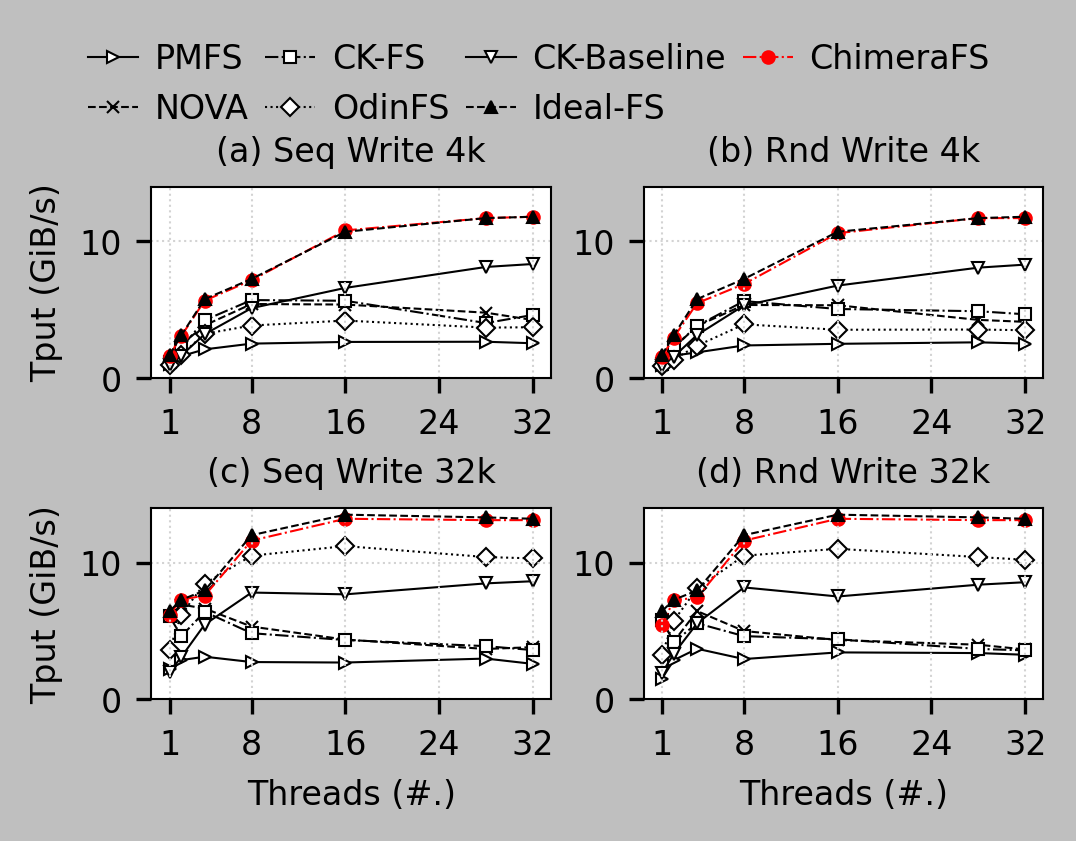

In [ ]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


with open("./performance-comparison-table-perf", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi=300, figsize=(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6)))

line_width = 0.5
marks = [">", "x", "s", "D", "v", "^", "o"]
line_patterns = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
fss = ["pmfs", "nova", "cknova", "odinfs-12", "optfs-12", "idel-12", "parfs-12"]
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs)
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024

mapping = {
    "nova": "NOVA",
    "cknova": "CK-FS",
    "pmfs": "PMFS",
    "odinfs-12": "OdinFS",
    "optfs-12": "CK-Baseline",
    "idel-12": "Ideal-FS",
    "parfs-12": "ChimeraFS"
}
mapped_fss = [mapping.get(item, item) for item in fss]

subplot_config = [
    # Upper row
    {'row': 0, 'col': 0, 'op': 'write', 'blksz': 4096, 'title_label': 'a', 'y_lims': [0, 14]},
    # {'row': 0, 'col': 1, 'op': 'write', 'blksz': 8192, 'title_label': 'b', 'y_lims': [0, 14]},
    # {'row': 0, 'col': 2, 'op': 'write', 'blksz': 16384, 'title_label': 'c', 'y_lims': [0, 14]},
    {'row': 0, 'col': 1, 'op': 'randwrite', 'blksz': 4096, 'title_label': 'b', 'y_lims': [0, 14]},
    # {'row': 0, 'col': 4, 'op': 'read', 'blksz': 4096, 'title_label': 'e', 'y_lims': [0, 35]},
    # {'row': 0, 'col': 5, 'op': 'read', 'blksz': 32768, 'title_label': 'f', 'y_lims': [0, 35]},
    # Lower row
    {'row': 1, 'col': 0, 'op': 'write', 'blksz': 32768, 'title_label': 'c', 'y_lims': [0, 14]},
    # {'row': 1, 'col': 1, 'op': 'randwrite', 'blksz': 8192, 'title_label': 'h', 'y_lims': [0, 14]},
    # {'row': 1, 'col': 2, 'op': 'randwrite', 'blksz': 16384, 'title_label': 'i', 'y_lims': [0, 14]},
    {'row': 1, 'col': 1, 'op': 'randwrite', 'blksz': 32768, 'title_label': 'd', 'y_lims': [0, 14]},
    # {'row': 1, 'col': 4, 'op': 'randread', 'blksz': 4096, 'title_label': 'k', 'y_lims': [0, 35]},
    # {'row': 1, 'col': 5, 'op': 'randread', 'blksz': 32768, 'title_label': 'l', 'y_lims': [0, 35]},
]

op_type_map = {
    'write': 'Seq Write',
    'randwrite': 'Rnd Write',
    'read': 'Seq Read',
    'randread': 'Rnd Read'
}

blksz_str_map = {
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k'
}

lines = []
for i, config in enumerate(subplot_config):
    plt.subplot(2, 2, i+1)
    op = config['op']
    blksz = config['blksz']
    
    op_type = op_type_map[op]
    blksz_str = blksz_str_map[blksz]
    plt.title(f"({config['title_label']}) {op_type} {blksz_str}", fontsize=8)
    
    for fs_idx, fs in enumerate(fss):
        op = "write" if fs == "idel-12" else config['op']
        data = df[(df['fs'] == fs) & (df['ops'] == op) & (df['blksz'] == blksz)]
        y = data['bandwidth'].iloc[:len(num_jobs)]
        
        if len(x) != len(y):
            print(f"Data mismatch: {fs} {op} {blksz}")
            continue
        
        if fs == "idel-12":
            markercolor = "black"
        elif fs == "parfs-12":
            markercolor = "red"
        else:
            markercolor = "white"

        if fs == "idel-12":
            markeredgecolor = "black"
        elif fs == "parfs-12":
            markeredgecolor = "red"
        else:
            markeredgecolor = "black"

        if fs == "idel-12":
            color = "black"
        elif fs == "parfs-12":
            color = "red"
        else:
            color = "black"
        
        if fs == "idel-12":
            zorder=10
        else:
            zorder=-1
        
        if i == 0:  # Only add labels to first subplot
            p, = plt.plot(x, y, color=color, marker=marks[fs_idx],
                          markerfacecolor=markercolor, markeredgecolor=markeredgecolor,
                          markersize=3, markeredgewidth=0.5,
                          linewidth=line_width, label=mapped_fss[fs_idx], linestyle=line_patterns[fs_idx], zorder=zorder)
            lines.append(p)
        else:
            plt.plot(x, y, color=color, marker=marks[fs_idx],
                     markerfacecolor=markercolor, markeredgecolor=markeredgecolor,
                     markersize=3, markeredgewidth=0.5,
                     linewidth=line_width, label='_nolegend_', linestyle=line_patterns[fs_idx], zorder=zorder)

    # Axis labels
    if config['col'] == 0:
        plt.ylabel('Tput (GiB/s)', fontsize=8)
    if config['row'] == 1:
        plt.xlabel('Threads (#.)', fontsize=8)
    
    # Formatting
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32], fontsize=8)
    plt.ylim(config['y_lims'])
    plt.yticks(fontsize=8)
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    # plt.tick_params(left=True, bottom=True, right=False, top=False, which='major', width=0.5, length=3)

fig.legend(lines, mapped_fss, loc='upper center', 
          bbox_to_anchor=(0.5, 1.15), ncol=4,
          columnspacing=0.5, handletextpad=0.5, 
          handlelength=1.5, frameon=False, fontsize=8,)

# plt.subplots_adjust(left=0.06, right=0.98, top=0.88, bottom=0.08,
#                    hspace=0.3, wspace=0.25)
plt.tight_layout(pad=0.4)
plt.savefig("./FIO-MOTIVATION.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
#!/usr/bin/env python3
import pandas as pd

# ① 读文件，统一列名
df = pd.read_csv(
    "./performance-comparison-table-perf",
    delim_whitespace=True,
    header=0,
    names=["fs", "ops", "filesz", "blksz", "numjobs", "bandwidth"]
)

# ② 只取 write 操作的 odinfs-12 和 pmfs 数据
cond = (df["ops"] == "write") & (df["fs"].isin(["odinfs-12", "pmfs"]))
df_write = df[cond].copy()

# ③ 分别取 odinfs 和 pmfs 的数据
odinfs = df_write[df_write["fs"] == "odinfs-12"][["filesz", "blksz", "numjobs", "bandwidth"]]
odinfs = odinfs.rename(columns={"bandwidth": "odinfs_bw"})

pmfs = df_write[df_write["fs"] == "pmfs"][["filesz", "blksz", "numjobs", "bandwidth"]]
pmfs = pmfs.rename(columns={"bandwidth": "pmfs_bw"})

# ④ 按 filesz + blksz + numjobs 对齐，计算带宽比值
merged = odinfs.merge(pmfs, on=["filesz", "blksz", "numjobs"], how="inner")
merged["ratio"] = merged["odinfs_bw"] / merged["pmfs_bw"]

# ⑤ 输出所有比值
print("===== odinfs / pmfs write 带宽比值（按 blksz 和 numjobs 分类）=====")
print(merged[["filesz", "blksz", "numjobs", "odinfs_bw", "pmfs_bw", "ratio"]])

# ⑥ 特别输出 numjobs == 32 且 blksz == 4096 情况
highlight = merged[(merged["numjobs"] == 32) & (merged["blksz"] == 4096)]

print("\n===== 重点关注：numjobs=32 且 blksz=4096 =====")
if not highlight.empty:
    row = highlight.iloc[0]
    print(
        f"filesz    : {row.filesz}\n"
        f"blksz     : {row.blksz}\n"
        f"numjobs   : {row.numjobs}\n"
        f"odinfs_bw : {row.odinfs_bw:.1f} MiB/s\n"
        f"pmfs_bw   : {row.pmfs_bw:.1f} MiB/s\n"
        f"比值(odinfs/pmfs): {row.ratio:.3f}"
    )
else:
    print("未找到符合条件的数据。")


===== odinfs / pmfs write 带宽比值（按 blksz 和 numjobs 分类）=====
    filesz  blksz  numjobs  odinfs_bw  pmfs_bw     ratio
0    32768   4096        1      964.0   1013.0  0.951629
1    32768  32768        1     3664.0   2250.0  1.628444
2    16384   4096        2     1741.0   1637.0  1.063531
3    16384  32768        2     6343.0   2924.0  2.169289
4     8192   4096        4     3311.0   2146.0  1.542870
5     8192  32768        4     8660.0   3182.0  2.721559
6     4096   4096        8     3932.0   2576.0  1.526398
7     4096  32768        8    10752.0   2781.0  3.866235
8     2048   4096       16     4304.0   2702.0  1.592894
9     2048  32768       16    11468.8   2745.0  4.178069
10    1170   4096       28     3777.0   2716.0  1.390648
11    1170  32768       28    10649.6   3042.0  3.500855
12    1024   4096       32     3803.0   2604.0  1.460445
13    1024  32768       32    10547.2   2643.0  3.990617

===== 重点关注：numjobs=32 且 blksz=4096 =====
filesz    : 1024.0
blksz     : 4096.0
numjobs

/tmp/ipykernel_240428/2831090663.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [ ]:
import pandas as pd

# 读取原始数据文件
filename = 'performance-comparison-table-perf'
df = pd.read_csv(filename, delim_whitespace=True)

# 只保留 write 操作、32线程（numjobs=32）
df = df[(df['ops'] == 'write') & (df['numjobs'] == 32)]

# 获取 idel-12 的数据
idel_df = df[df['fs'] == 'idel-12']

# 排除 idel-12 和 parfs-12，仅保留其他文件系统
other_fs_list = df[~df['fs'].isin(['idel-12', 'parfs-12'])]['fs'].unique()

# 准备输出数据
output_rows = []

# 遍历每个文件系统
for fs in other_fs_list:
    fs_df = df[df['fs'] == fs]
    ratios = []

    for _, row in fs_df.iterrows():
        # 找到对应的 idel-12 条目（同样的块大小和线程数）
        matched = idel_df[
            (idel_df['blksz'] == row['blksz']) &
            (idel_df['numjobs'] == row['numjobs'])
        ]
        if not matched.empty:
            idel_bw = matched['bandwidth(MiB/s)'].values[0]
            ratio = idel_bw / row['bandwidth(MiB/s)']
            if ratio > 1:
                ratios.append({
                    'fs': fs,
                    'blksz': row['blksz'],
                    'numjobs': row['numjobs'],
                    'idel_bw': idel_bw,
                    'fs_bw': row['bandwidth(MiB/s)'],
                    'ratio': ratio,
                    'extreme': ''
                })

    if ratios:
        ratio_df = pd.DataFrame(ratios)
        max_idx = ratio_df['ratio'].idxmax()
        min_idx = ratio_df['ratio'].idxmin()

        ratio_df.loc[max_idx, 'extreme'] = 'max'
        ratio_df.loc[min_idx, 'extreme'] = 'min'

        output_rows.extend(ratio_df.loc[[max_idx, min_idx]].to_dict(orient='records'))

# 写入 CSV 文件
output_df = pd.DataFrame(output_rows)
output_df = output_df[['fs', 'extreme', 'blksz', 'numjobs', 'idel_bw', 'fs_bw', 'ratio']]
output_df.to_csv('idel_write_ratio_32threads.csv', index=False)

print("32线程下的write性能比值已保存至文件：idel_write_ratio_32threads.csv")



32线程下的write性能比值已保存至文件：idel_write_ratio_32threads.csv


/tmp/ipykernel_240428/1702209977.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True)


In [ ]:
def main():
    data = {}
    with open('performance-comparison-table-perf', 'r') as file:
        lines = file.readlines()
    
    # 跳过标题行
    for line in lines[1:]:
        parts = line.split()
        if len(parts) < 6:
            continue
        fs = parts[0]
        ops = parts[1]
        filesz = int(parts[2])
        blksz = int(parts[3])
        numjobs = int(parts[4])
        bandwidth = float(parts[5])
        
        # 只处理 idel-12 和 optfs-12
        if fs not in ['idel-12', 'optfs-12']:
            continue
            
        key = (ops, filesz, blksz, numjobs)
        if key not in data:
            data[key] = {'idel': None, 'optfs': None}
        
        if fs == 'idel-12':
            data[key]['idel'] = bandwidth
        elif fs == 'optfs-12':
            data[key]['optfs'] = bandwidth
            
    gaps = []
    for key, values in data.items():
        idel_bw = values['idel']
        optfs_bw = values['optfs']
        if idel_bw is not None and optfs_bw is not None:
            gap = (idel_bw - optfs_bw) / idel_bw
            gaps.append(gap)
            print(f"Setting: {key}, Gap: {gap:.2f} MiB/s")
        else:
            print(f"Setting: {key} has missing data (idel: {idel_bw}, optfs: {optfs_bw})")
            
    if gaps:
        max_gap = max(gaps)
        min_gap = min(gaps)
        print(f"\nMaximum performance gap: {max_gap:.2f} MiB/s")
        print(f"Minimum performance gap: {min_gap:.2f} MiB/s")
    else:
        print("No valid data pairs found.")

if __name__ == '__main__':
    main()

Setting: ('write', 32768, 4096, 1), Gap: 0.44 MiB/s
Setting: ('randwrite', 32768, 4096, 1), Gap: 0.44 MiB/s
Setting: ('write', 32768, 32768, 1), Gap: 0.69 MiB/s
Setting: ('randwrite', 32768, 32768, 1), Gap: 0.69 MiB/s
Setting: ('write', 16384, 4096, 2), Gap: 0.47 MiB/s
Setting: ('randwrite', 16384, 4096, 2), Gap: 0.48 MiB/s
Setting: ('write', 16384, 32768, 2), Gap: 0.58 MiB/s
Setting: ('randwrite', 16384, 32768, 2), Gap: 0.54 MiB/s
Setting: ('write', 8192, 4096, 4), Gap: 0.44 MiB/s
Setting: ('randwrite', 8192, 4096, 4), Gap: 0.43 MiB/s
Setting: ('write', 8192, 32768, 4), Gap: 0.31 MiB/s
Setting: ('randwrite', 8192, 32768, 4), Gap: 0.31 MiB/s
Setting: ('write', 4096, 4096, 8), Gap: 0.29 MiB/s
Setting: ('randwrite', 4096, 4096, 8), Gap: 0.24 MiB/s
Setting: ('write', 4096, 32768, 8), Gap: 0.35 MiB/s
Setting: ('randwrite', 4096, 32768, 8), Gap: 0.31 MiB/s
Setting: ('write', 2048, 4096, 16), Gap: 0.38 MiB/s
Setting: ('randwrite', 2048, 4096, 16), Gap: 0.36 MiB/s
Setting: ('write', 2048, 327